# Nudging: How memorisation of Large Language Models scale

How Do Large Language Models Complete Unseen Creative Texts? 

This is a behavioral study across post-cutoff cultural artifacts and private works.


Research


What I plan to contribute:
1. taxonomy of how different models respond when asked to continue unseen creative content (do they refuse, paraphrase, hallucinate or copy)
2. Compare across different types of content and model families
3. How does prefix length and popularity impact the models ability to copy it vs hallucinate
4. private controlled dataset for showing generalisation vs memorisation

## Experiment background

### Reading list

1. Quantifying Memorization Across Neural Language Models [link](https://arxiv.org/abs/2202.07646)
2. Extracting Training Data from Large Language Models [Link](https://arxiv.org/pdf/2012.07805)
3. Scalable Extraction of Training Data from (Production) Language Models [Link](https://arxiv.org/pdf/2311.17035)
4. A Comprehensive Analysis of Memorization in Large Language Models [Link](https://aclanthology.org/2024.inlg-main.45/)
5. Understanding Memorisation in LLMs: Dynamics, Influencing Factors, and Implications [Link](https://arxiv.org/pdf/2407.19262v1)
6. Skewed Memorization in Large Language Models: Quantification and Decomposition [Link](https://arxiv.org/pdf/2502.01187v1)
Important background reading
7. SoK: Memorization in General-Purpose Large Language Models [Link](https://arxiv.org/abs/2310.18362)
8. The Landscape of Memorization in LLMs: Mechanisms, Measurement, and Mitigation [Link](https://arxiv.org/html/2507.05578v1)
9. Measuring Memorization in Language Models via Probabilistic Extraction [Link](https://arxiv.org/html/2410.19482v2)
Important methodologically
10. Rethinking LLM Memorization (CMU blog paper) [Link](https://blog.ml.cmu.edu/2024/09/13/rethinking-llm-memorization/)
11. RECAP: Reproducing Copyrighted Data from LLMs Training with an Agentic Pipeline [Link](https://arxiv.org/html/2510.25941)
12. Leaner Training, Lower Leakage: Revisiting Memorization in LLM Fine-Tuning with LoRA [Link](https://arxiv.org/html/2506.20856v1)
Extra readings
13. MEMLENS: Uncovering Memorization in LLMs with Activation Trajectories [Link](https://arxiv.org/pdf/2509.20909)
14. To Each (Textual Sequence) Its Own: Improving Memorized-Data Unlearning in Large Language Models [Link](https://arxiv.org/html/2405.03097v1)
15. ChatMusician: Understanding and Generating Music Intrinsically with LLM [Link](https://arxiv.org/html/2402.16153v1)

### Experiment details


How much nudging does an LLM need to copy an artists work?

If we feed an artists work (e.g. music lyrics, book, blog) that is new to an LLM API endpoint one word at a time, how long till it produces the same text? In 5%, 20% 99%? Compare different models. Benefit here is that it will look at what data has trained models & plagiarism. This is a new eval. Feed it one word at a time of a new creative (e.g. a song). How long till it is able to recreate it? How much context does it need to recreate something that already exists? is this a measure of model creativity or what we already do with evals?

Other spin on this that is really powerful: how long till the model creates something new on the market already? E.g. a new song from kendrick, new youtube video by a speaker? This can help measure what the model has been trained on already too. How close is it to data e.g. trained on a lot of jordan peterson perhaps?

# Setup

Verifying connection to ollama

In [1]:
import requests
import json
from typing import List, Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
def test_ollama():
    """Check connection to Ollama"""
    try:
        response = requests.get("http://localhost:11434/api/tags")
        models = response.json()
        print("✅ Ollama is live")
        print(f"Available models: {[m['name'] for m in models['models']]}")
        return True
    except:
        print("❌ Ollama is not running")
        return False

In [4]:
test_ollama()

✅ Ollama is live
Available models: ['qwen3:0.6b']


True

In [ ]:
def generate_text(prompt:str, model:str='qwen3:0.6b', temperature:float=0.7) -> str:
    """Generate text using Ollama"""
    url="http://localhost:11434/api/generate"
    data={
        "model": model,
        "prompt": prompt,
        "stream": False,
        "think": False,
        "options": {
            "temperature": 0.6
        }
    }

    response = requests.post(url, json=data)
    return response.json()["response"]

test_prompt = "Continue this song lyric: You are my fire The one desire"
result = generate_text(test_prompt)
print(f'output: {result}')

output: You are my fire, the one desire  
The night is gone, the stars are gone,  
I’ll burn with you, I’ll burn with you.  
Your laughter will be my flame,  
A song of love, a song of life.


# 2: First experiment

In [ ]:
import requests
import pandas
import matplotlib.pyplot as plt
from rapidfuzz import fuzz
import numpy as np

In [6]:
from sentence_transformers import SentenceTransformer
from collections import defaultdict

In [15]:
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

We will need to load semantic model 

In [7]:
def get_split_text(text: str, percentage: float) -> dict:
    """Split text into test portion and remaining portion"""
    d = defaultdict(str)
    words = text.split()
    chunk_size = int(len(words) * (percentage / 100))
    d['test_words'] = " ".join(words[:chunk_size])
    d['remaining_words'] = " ".join(words[chunk_size:])
    return d

# Test it
test_text = "Hello world this is a test sentence with many words"
result = get_split_text(test_text, 50)
print(f"Test words: {result['test_words']}")
print(f"Remaining: {result['remaining_words']}")

Test words: Hello world this is a
Remaining: test sentence with many words


In [9]:
SAMPLE_CONTENT = """
Yeah

You are my fire
The one desire
Believe when I say
I want it that way

But we are two worlds apart
Can't reach to your heart
When you say
That I want it that way

Tell me why
Ain't nothin' but a heartache
Tell me why
Ain't nothing but a mistake
Tell me why
I never wanna hear you say
I want it that way

Am I your fire?
Your one desire
Yes, I know it's too late
But I want it that way

Tell me why
Ain't nothin' but a heartache
Tell me why
Ain't nothin' but a mistake
Tell me why
I never wanna hear you say
I want it that way

Now I can see that we've fallen apart
From the way that it used to be, yeah
No matter the distance, I want you to know
That deep down inside of me

You are my fire
The one desire
You are (You are, you are, you are)
Don't wanna hear you say

Ain't nothin' but a heartache (Hey, yeah)
Ain't nothin' but a mistake (Don't wanna hear you say)
I never wanna hear you say (Oh, yeah)
I want it that way

Tell me why
Ain't nothin' but a heartache
Tell me why
Ain't nothin' but a mistake
Tell me why
I never wanna hear you say (Don't wanna hear you say)
I want it that way
Tell me why
Ain't nothin' but a heartache
Ain't nothin' but a mistake
Tell me why
I never wanna hear you say (Never wanna hear you say, yeah)
I want it that way

'Cause I want it that way
"""

In [10]:
print(f"Total words: {len(SAMPLE_CONTENT.split())}")

Total words: 272


In [ ]:
print(f"Content length: {len(SAMPLE_CONTENT)} characters")

Content length: 1284 characters
Word count: 272


In [12]:
def fuzzy_match_score(generated:str, target:str) -> float:
    """compare 2 texts using fuzzy matching (Levenshtein distance).
    Returns between 0.0 -> 1.0 (the higher, the more similar)"""
    return fuzz.ratio(generated.lower(), target.lower()) / 100.0

In [19]:
def exact_match_score(generated:str,target:str) -> float:
    """Simple exact character match"""
    generated_cleaned = generated.lower().strip()
    target_cleaned = target.lower().strip()
    if not target_cleaned:
        return 0.0
    matches = sum(1 for a, b in zip(generated_cleaned, target_cleaned) if a==b)
    return matches/len(target_cleaned)

In [21]:
def token_overlap_score(generated:str, target:str) -> float:
    generated_tokens = set(generated.lower().split())
    target_tokens = set(target.lower().split())
    if not target_tokens:
        return 0.0
    intersection = len(generated_tokens & target_tokens)
    union = len(generated_tokens | target_tokens)
    return intersection / union if union > 0 else 0.0

In [22]:
def semantic_similarity_score(generated:str, target:str, model) -> float:
    "cosine similarity of embeddings"
    if not generated.strip() or not target.strip():
        return 0.0
    embeddings = model.encode([generated, target])
    similarity = np.dot(embeddings[0], embeddings[1]) / (
        np.linalg.norm(embeddings[0]) * np.linalg.norm(embeddings[1])
    )
    return float(similarity)

In [50]:
def run_experiment(content:str, percentage:float, model_name:str="qwen3:0.6b"):
    """Run one experiment at a given percentage"""
    split_text = get_split_text(content, percentage)
    context = split_text['test_words']
    target = split_text['remaining_words']

    prompt = f"""Continue this text:

{context}
        
Continue:"""
    
    print(f"\n{'='*60}")
    print(f"Testing at {percentage}% context")
    print(f"Context: {len(context.split())} words")
    print(f"Target: {len(target.split())} words")

    url="http://localhost:11434/api/generate"
    data={
        "model": model_name,
        "prompt": prompt,
        "stream": False,
        "options": {
            "temperature": 0.7
        }
    }

    response = requests.post(url, json=data)
    generated = response.json()["response"]

    print(f"\nGenerated ({len(generated.split())} words):")
    print(generated[:200], "...")

    # Calculate metrics
    metrics = {
        "percentage": percentage,
        "context_words": len(context.split()),
        "target_words": len(target.split()),
        "generated_words": len(generated.split()),
        "exact_match": exact_match_score(generated, target),
        "fuzzy_match": fuzzy_match_score(generated, target),
        "token_overlap": token_overlap_score(generated, target),
        "semantic_similarity": semantic_similarity_score(generated, target, semantic_model),
    }
    
    print(f"\nMetrics:")
    for k, v in metrics.items():
        if isinstance(v, float) and k != "percentage":
            print(f"  {k}: {v:.3f}")
    
    return metrics    

In [27]:
# Test with one percentage
result = run_experiment(SAMPLE_CONTENT, model_name='qwen3:0.6b', percentage=20)


Testing at 20% context
Context: 54 words
Target: 218 words

Generated (94 words):
But can't reach to your heart, nor can I see the light. For even the stars in the night are a reflection of our own. When you say that I want it that way, I see only the shadow of my own pain. And in  ...

Metrics:
  exact_match: 0.038
  fuzzy_match: 0.389
  token_overlap: 0.179
  semantic_similarity: 0.320


In [29]:
# Cell 6: Run Multiple Experiments
percentages = [0, 5, 10, 20, 30, 50, 75, 90]
results = []

for pct in tqdm(percentages, desc="Running experiments"):
    result = run_experiment(SAMPLE_CONTENT, pct,'qwen3:0.6b')
    results.append(result)

Running experiments:   0%|          | 0/8 [00:00<?, ?it/s]


Testing at 0% context
Context: 0 words
Target: 272 words

Generated (31 words):
Okay, let me see... I need to continue the text they provided. But since they haven't given it yet, I can't start. Please provide the text you'd like me to continue. ...


Running experiments:  12%|█▎        | 1/8 [00:03<00:23,  3.35s/it]


Metrics:
  exact_match: 0.017
  fuzzy_match: 0.189
  token_overlap: 0.078
  semantic_similarity: 0.128

Testing at 5% context
Context: 13 words
Target: 259 words

Generated (7 words):
And let your love be the flame. ...


Running experiments:  25%|██▌       | 2/8 [00:09<00:28,  4.76s/it]


Metrics:
  exact_match: 0.003
  fuzzy_match: 0.048
  token_overlap: 0.026
  semantic_similarity: 0.260

Testing at 10% context
Context: 27 words
Target: 245 words


Running experiments:  38%|███▊      | 3/8 [00:14<00:26,  5.23s/it]


Generated (44 words):
light that dances through the night,  
a flame that never fades,  
your shadow in the storm,  
my truth in the storm.  

Can't reach to your heart,  
but I'll keep the fire burning,  
for even the dar ...

Metrics:
  exact_match: 0.020
  fuzzy_match: 0.267
  token_overlap: 0.100
  semantic_similarity: 0.348

Testing at 20% context
Context: 54 words
Target: 218 words


Running experiments:  50%|█████     | 4/8 [00:20<00:20,  5.22s/it]


Generated (100 words):
Tell me why ain't nothing but a heartache,  
And why ain't nothing but a mistake,  
Though the world may not be mine,  
And the heart may not be mine,  
Can't we find our way?  
What if we one day  
W ...

Metrics:
  exact_match: 0.053
  fuzzy_match: 0.417
  token_overlap: 0.128
  semantic_similarity: 0.448

Testing at 30% context
Context: 81 words
Target: 191 words

Generated (134 words):
But how can I be your fire? Or just a shadow? I’ve seen the world through your eyes, and I’ve seen your heart’s truth in the way you say, “Am I your fire?” Your one desire is not just a flame, but a t ...


Running experiments:  62%|██████▎   | 5/8 [00:27<00:17,  5.87s/it]


Metrics:
  exact_match: 0.062
  fuzzy_match: 0.442
  token_overlap: 0.190
  semantic_similarity: 0.401

Testing at 50% context
Context: 136 words
Target: 136 words


Running experiments:  75%|███████▌  | 6/8 [00:35<00:13,  6.69s/it]


Generated (132 words):
Now I can see that we've fallen apart From the way that it used to be, yeah No matter the time, I still hold on to your fire. The echoes of our once-loyal bond still whisper through the silence, but n ...

Metrics:
  exact_match: 0.088
  fuzzy_match: 0.482
  token_overlap: 0.147
  semantic_similarity: 0.359

Testing at 75% context
Context: 204 words
Target: 68 words


Running experiments:  88%|████████▊ | 7/8 [00:45<00:07,  7.67s/it]


Generated (134 words):
You are my fire  
The one desire You are (You are, you are, you are)  
Don't wanna hear you say Ain't nothin' but a heartache  
(Hey, yeah) Ain't nothin' but a mistake (Don't wanna hear you say)  
I n ...

Metrics:
  exact_match: 0.071
  fuzzy_match: 0.514
  token_overlap: 0.351
  semantic_similarity: 0.725

Testing at 90% context
Context: 244 words
Target: 28 words

Generated (47 words):
Ain't nothin' but a heartache  
Tell me why I never wanna hear you say (Don't wanna hear you say) I want it that way  
Tell me why Ain't nothin' but a heartache Ain't nothin' but  
(Oh, yeah) I want i ...


Running experiments: 100%|██████████| 8/8 [01:16<00:00,  9.55s/it]


Metrics:
  exact_match: 0.087
  fuzzy_match: 0.609
  token_overlap: 0.577
  semantic_similarity: 0.618


In [30]:
# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results

,percentage,context_words,target_words,generated_words,exact_match,fuzzy_match,token_overlap,semantic_similarity
0,0,0,272,31,0.016509,0.189283,0.077778,0.127936
1,5,13,259,7,0.003292,0.048154,0.026316,0.259921
2,10,27,245,44,0.020000,0.267143,0.100000,0.348431
3,20,54,218,100,0.052941,0.417219,0.127660,0.448416
4,30,81,191,134,0.061878,0.442146,0.189655,0.401477
5,50,136,136,132,0.088415,0.482344,0.146552,0.358507
6,75,204,68,134,0.071207,0.513541,0.350877,0.724528
7,90,244,28,47,0.087302,0.608696,0.576923,0.617840


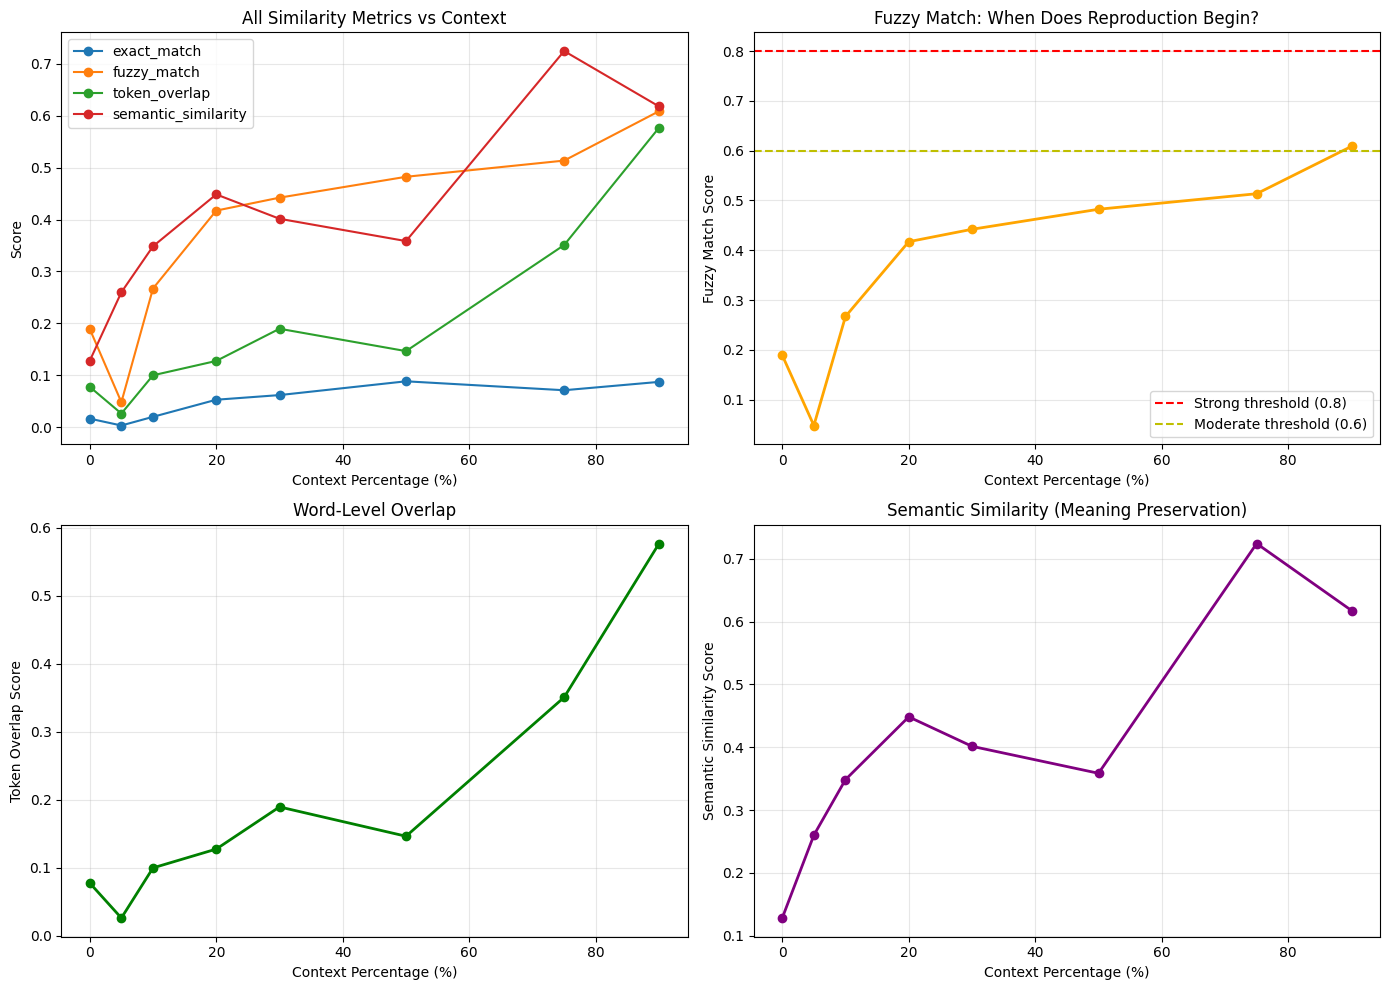

In [39]:
# Cell 7: Visualize Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: All metrics vs percentage
ax1 = axes[0, 0]
metrics_to_plot = ['exact_match', 'fuzzy_match', 'token_overlap', 'semantic_similarity']
for metric in metrics_to_plot:
    ax1.plot(df_results['percentage'], df_results[metric], marker='o', label=metric)
ax1.set_xlabel('Context Percentage (%)')
ax1.set_ylabel('Score')
ax1.set_title('All Similarity Metrics vs Context')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Fuzzy match focus
ax2 = axes[0, 1]
ax2.plot(df_results['percentage'], df_results['fuzzy_match'], marker='o', linewidth=2, color='orange')
ax2.axhline(y=0.8, color='r', linestyle='--', label='Strong threshold (0.8)')
ax2.axhline(y=0.6, color='y', linestyle='--', label='Moderate threshold (0.6)')
ax2.set_xlabel('Context Percentage (%)')
ax2.set_ylabel('Fuzzy Match Score')
ax2.set_title('Fuzzy Match: When Does Reproduction Begin?')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Token overlap
ax3 = axes[1, 0]
ax3.plot(df_results['percentage'], df_results['token_overlap'], marker='o', linewidth=2, color='green')
ax3.set_xlabel('Context Percentage (%)')
ax3.set_ylabel('Token Overlap Score')
ax3.set_title('Word-Level Overlap')
ax3.grid(True, alpha=0.3)

# Plot 4: Semantic similarity
ax4 = axes[1, 1]
ax4.plot(df_results['percentage'], df_results['semantic_similarity'], marker='o', linewidth=2, color='purple')
ax4.set_xlabel('Context Percentage (%)')
ax4.set_ylabel('Semantic Similarity Score')
ax4.set_title('Semantic Similarity (Meaning Preservation)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Part 3: e2e

In [45]:
from pathlib import Path
import re
import pandas as pd

# --- podcast-specific cleaner ---
_TS_INLINE = re.compile(r'\b(?:\d{1,2}:)?\d{1,2}:\d{2}\b')   # hh:mm:ss or m:ss or mm:ss
_TS_LINE   = re.compile(r'^\s*(?:\d{1,2}:)?\d{1,2}:\d{2}\s*$') # timestamp-only lines
_SPEAKER   = re.compile(r'^\s*[A-Z][A-Z\s.\'-]{2,}:\s+')       # ALLCAPS NAME:
_BRACKETED = re.compile(r'\s*\[(?:MUSIC|APPLAUSE|LAUGHTER|SFX)[^\]]*\]\s*', re.I)

In [46]:

def preprocess_text(category: str, text: str) -> str:
    """Category-aware prep. For 'podcasts', strip timestamps, speaker tags, and stage cues."""
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    if category.lower() == "podcasts":
        cleaned_lines = []
        for line in text.split("\n"):
            # drop pure timestamp lines (e.g., "0:05", "01:12:33")
            if _TS_LINE.match(line):
                continue
            # remove bracketed cues like [MUSIC PLAYING], [APPLAUSE]
            line = _BRACKETED.sub(" ", line)
            # strip inline timestamps inside the sentence
            line = _TS_INLINE.sub(" ", line)
            # remove ALLCAPS speaker labels at start of line: "ANDREW HUBERMAN: ..."
            line = _SPEAKER.sub("", line)
            # collapse leftover whitespace
            line = re.sub(r'\s+', ' ', line).strip()
            if line:
                cleaned_lines.append(line)
        text = "\n".join(cleaned_lines)

    # light normalisation for everything
    text = re.sub(r'\n{3,}', "\n\n", text).strip()
    return text

# --- simple loader that applies the prep step ---
def load_contents_by_structure(
    base_dir: str | Path = "data",
    exts = (".txt",),
    min_words: int = 30,
):
    """
    Load texts from: base_dir/category/owner/name.txt
    Returns: (contents_dict, inventory_df)
      - contents_dict keys: 'category::owner::name'
    """
    base = Path(base_dir)
    contents = {}
    records = []

    for p in base.rglob("*"):
        if not p.is_file() or p.suffix.lower() not in exts:
            continue

        try:
            rel = p.relative_to(base)
        except ValueError:
            continue

        parts = rel.parts
        if len(parts) < 3:
            continue

        category, owner = parts[0], parts[1]
        name = p.stem

        raw = p.read_text(encoding="utf-8", errors="ignore")
        text = preprocess_text(category, raw)
        words = len(text.split())
        kept = words >= min_words
        key = f"{category}::{owner}::{name}"

        if kept:
            contents[key] = text

        records.append({
            "key": key,
            "path": str(p),
            "category": category,
            "owner": owner,
            "name": name,
            "ext": p.suffix.lower(),
            "words": words,
            "kept": kept,
        })

    inv = pd.DataFrame.from_records(records).sort_values(["category", "owner", "name"])
    return contents, inv


In [47]:
contents, inv = load_contents_by_structure("data", exts=(".txt",), min_words=30)
print(f"Loaded {sum(inv.kept)} files (of {len(inv)})")

Loaded 3 files (of 3)


In [48]:
inv

,key,path,category,owner,name,ext,words,kept
0,podcasts::huberman::how_to_build_immense_inner...,data/podcasts/huberman/how_to_build_immense_in...,podcasts,huberman,how_to_build_immense_inner_strength_David_Goggins,.txt,27446,True
2,songs::taylor_swift::shake_it_off,data/songs/taylor_swift/shake_it_off.txt,songs,taylor_swift,shake_it_off,.txt,560,True
1,songs::taylor_swift::the_fate_of_ophelia,data/songs/taylor_swift/the_fate_of_ophelia.txt,songs,taylor_swift,the_fate_of_ophelia,.txt,432,True


In [51]:
all_results = []
for key, content_text in contents.items():
    print("\n" + "#"*60)
    print(f"Testing: {key}")
    print("#"*60)
    for pct in [10, 20, 30, 50, 75]:
        res = run_experiment(content_text, pct)
        res["content_name"] = key  # e.g., "podcasts::huberman::how_to_build_strength"
        all_results.append(res)

df_all = pd.DataFrame(all_results)


############################################################
Testing: podcasts::huberman::how_to_build_immense_inner_strength_David_Goggins
############################################################

Testing at 10% context
Context: 2744 words
Target: 24702 words

Generated (240 words):
ANDREW HUBERMAN: I'm also very interested in how the science of learning and memory can be applied to everyday life. For instance, in the field of medicine, the study of human physiology and the devel ...

Metrics:
  exact_match: 0.001
  fuzzy_match: 0.021
  token_overlap: 0.026
  semantic_similarity: 0.477

Testing at 20% context
Context: 5489 words
Target: 21957 words

Generated (260 words):
And so, as I sit now, my hands still clutching the worn leather of my shoes, my mind a mosaic of the past and the present. The stories I tell, the people I’ve built with, the moments I’ve turned my li ...

Metrics:
  exact_match: 0.001
  fuzzy_match: 0.022
  token_overlap: 0.030
  semantic_similarity: 0.549

Tes

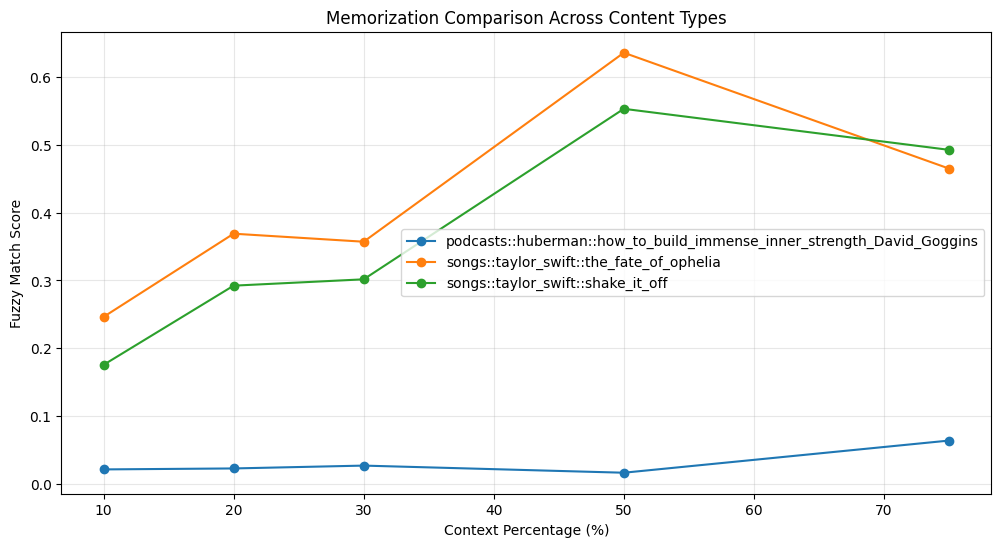

Average scores by content type:
                                                    fuzzy_match  \
content_name                                                      
podcasts::huberman::how_to_build_immense_inner_...     0.029976   
songs::taylor_swift::shake_it_off                      0.363144   
songs::taylor_swift::the_fate_of_ophelia               0.414791   

                                                    token_overlap  \
content_name                                                        
podcasts::huberman::how_to_build_immense_inner_...       0.030590   
songs::taylor_swift::shake_it_off                        0.173682   
songs::taylor_swift::the_fate_of_ophelia                 0.234250   

                                                    semantic_similarity  
content_name                                                             
podcasts::huberman::how_to_build_immense_inner_...             0.395813  
songs::taylor_swift::shake_it_off                              0

In [52]:
# Cell 3: Compare across content types
fig, ax = plt.subplots(figsize=(12, 6))

for content_name in df_all['content_name'].unique():
    subset = df_all[df_all['content_name'] == content_name]
    ax.plot(subset['percentage'], subset['fuzzy_match'], marker='o', label=content_name)

ax.set_xlabel('Context Percentage (%)')
ax.set_ylabel('Fuzzy Match Score')
ax.set_title('Memorization Comparison Across Content Types')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Cell 4: Summary statistics
summary = df_all.groupby('content_name')[['fuzzy_match', 'token_overlap', 'semantic_similarity']].mean()
print("Average scores by content type:")
print(summary)